# Radio Map 补全任务 - 基于RME-GAN的实现

## 任务说明
- 输入：带有20%像素缺失的Radio Map（256×256灰度图）
- 输出：完整的Radio Map预测
- 评估指标：NMSE (Normalized Mean Square Error)
- 框架：PyTorch
- 方法：基于RME-GAN（条件生成对抗网络）的改进版本

## 1. 环境配置和导入库

In [1]:
# 基础库
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch相关
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

# 设置随机种子
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 检查GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

Using device: cuda
GPU: NVIDIA GeForce RTX 5090
Memory: 31.36 GB


## 2. 数据路径配置

In [2]:
# 数据路径（使用相对路径）
# BASE_PATH为当前目录
TRAIN_PATH = os.path.join('Data', 'train')
TEST_PATH = os.path.join('Data', 'test(student)')
MASK_PATH = os.path.join(TEST_PATH, 'mask.csv')

# 输出路径 - 使用组合损失方法命名
OUTPUT_PATH = 'output_combined_loss'
MODEL_PATH = 'models_combined_loss'
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

print(f"训练数据路径: {TRAIN_PATH}")
print(f"测试数据路径: {TEST_PATH}")
print(f"遮罩文件路径: {MASK_PATH}")

训练数据路径: Data/train
测试数据路径: Data/test(student)
遮罩文件路径: Data/test(student)/mask.csv


## 3. 数据加载和预处理

In [3]:
# 读取mask信息
def load_masks(mask_path):
    """加载遮罩位置信息"""
    masks = []
    with open(mask_path, 'r') as f:
        for line in f:
            coords = line.strip().split(',')
            if len(coords) == 4:
                masks.append([int(x) for x in coords])
    return masks

# 应用遮罩到图像
def apply_masks_to_image(img, masks, fill_value=0.5):
    """将遮罩应用到图像上"""
    img_masked = img.copy()
    mask_binary = np.ones_like(img)
    
    for mask in masks:
        x1, y1, x2, y2 = mask
        # 注意：mask.csv的坐标是包含边界的，但Python切片是左闭右开
        # 所以需要x2+1和y2+1来包含第x2列和第y2行
        img_masked[y1:y2+1, x1:x2+1] = fill_value  # 修正：包含边界
        mask_binary[y1:y2+1, x1:x2+1] = 0
    
    return img_masked, mask_binary

# 自定义数据集
class RadioMapDataset(Dataset):
    def __init__(self, data_path, masks=None, mode='train', transform=None):
        """
        mode: 'train', 'val', or 'test'
        """
        self.data_path = data_path
        self.masks = masks
        self.mode = mode
        self.transform = transform
        
        # 获取所有图像文件
        self.image_files = sorted([f for f in os.listdir(data_path) if f.endswith('.png')])
        
        if mode == 'train':
            # 训练集划分：90%训练，10%验证
            n_train = int(len(self.image_files) * 0.9)
            self.image_files = self.image_files[:n_train]
        elif mode == 'val':
            n_train = int(len(self.image_files) * 0.9)
            self.image_files = self.image_files[n_train:]
            
        print(f"{mode} dataset size: {len(self.image_files)}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # 读取图像
        img_path = os.path.join(self.data_path, self.image_files[idx])
        img = Image.open(img_path).convert('L')
        img = np.array(img, dtype=np.float32) / 255.0  # 归一化到[0,1]
        
        if self.mode in ['train', 'val']:
            # 训练/验证模式：使用全部144个10x10遮罩（与测试一致）
            if self.masks:
                img_masked, mask_binary = apply_masks_to_image(img, self.masks, fill_value=0.5)
            else:
                # 如果没有提供遮罩，随机生成
                img_masked, mask_binary = self.generate_random_masks(img)
            
            # 转换为张量
            img_tensor = torch.from_numpy(img).unsqueeze(0)  # [1, H, W]
            img_masked_tensor = torch.from_numpy(img_masked).unsqueeze(0)
            mask_tensor = torch.from_numpy(mask_binary).unsqueeze(0)
            
            return {
                'input': img_masked_tensor,
                'target': img_tensor,
                'mask': mask_tensor,
                'filename': self.image_files[idx]
            }
        else:
            # 测试模式
            if self.masks:
                img_masked, mask_binary = apply_masks_to_image(img, self.masks, fill_value=0.5)
            else:
                img_masked = img
                mask_binary = np.ones_like(img)
            
            img_tensor = torch.from_numpy(img).unsqueeze(0)  # 添加原始图像
            img_masked_tensor = torch.from_numpy(img_masked).unsqueeze(0)
            mask_tensor = torch.from_numpy(mask_binary).unsqueeze(0)
            
            return {
                'input': img_masked_tensor,
                'original': img_tensor,  # 保存原始图像用于后处理
                'mask': mask_tensor,
                'filename': self.image_files[idx]
            }
    
    def generate_random_masks(self, img):
        """生成随机遮罩"""
        h, w = img.shape
        img_masked = img.copy()
        mask_binary = np.ones_like(img)
        
        # 生成10-20个随机矩形遮罩
        n_masks = random.randint(10, 20)
        for _ in range(n_masks):
            # 随机大小和位置
            mask_h = random.randint(5, 15)
            mask_w = random.randint(5, 15)
            x = random.randint(0, w - mask_w)
            y = random.randint(0, h - mask_h)
            
            img_masked[y:y+mask_h, x:x+mask_w] = 0.5
            mask_binary[y:y+mask_h, x:x+mask_w] = 0
        
        return img_masked, mask_binary

# 加载遮罩信息
masks = load_masks(MASK_PATH)
print(f"加载了 {len(masks)} 个遮罩")
print(f"示例遮罩: {masks[:3]}")
print(f"训练和测试都使用全部 {len(masks)} 个 10x10 遮罩")
print("修正：使用[y1:y2+1, x1:x2+1]来正确包含边界")
print("填充值：fill_value=0.5（中间灰度）")

加载了 144 个遮罩
示例遮罩: [[3, 3, 13, 13], [24, 3, 34, 13], [46, 3, 56, 13]]
训练和测试都使用全部 144 个 10x10 遮罩
修正：使用[y1:y2+1, x1:x2+1]来正确包含边界
填充值：fill_value=0.5（中间灰度）


## 4. 模型架构定义 - ResNet生成器（来自RME-GAN）

In [4]:
# ResNet块定义
class ResnetBlock(nn.Module):
    """ResNet残差块"""
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        
        # 第一个卷积层
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError(f'padding {padding_type} is not implemented')

        conv_block += [
            nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
            norm_layer(dim),
            nn.ReLU(True)
        ]
        
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        # 第二个卷积层
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
            
        conv_block += [
            nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
            norm_layer(dim)
        ]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)  # 残差连接
        return out


# ResNet生成器
class ResnetGenerator(nn.Module):
    """基于ResNet的生成器网络"""
    def __init__(self, input_nc=2, output_nc=1, ngf=64, norm_layer=nn.BatchNorm2d, 
                 use_dropout=False, n_blocks=4, padding_type='reflect'):
        """
        input_nc: 输入通道数（带遮罩图像 + 遮罩二值图）
        output_nc: 输出通道数
        ngf: 生成器基础特征数
        n_blocks: ResNet块数量
        """
        super(ResnetGenerator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d
        
        # 初始卷积块
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
            norm_layer(ngf),
            nn.ReLU(True)
        ]
        
        # 下采样
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                norm_layer(ngf * mult * 2),
                nn.ReLU(True)
            ]
        
        # ResNet块
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, 
                                use_dropout=use_dropout, use_bias=use_bias)]
        
        # 上采样
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), 
                                   kernel_size=3, stride=2, padding=1, output_padding=1, bias=use_bias),
                norm_layer(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]
        
        # 输出层
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
            nn.Sigmoid()  # 输出范围[0,1]
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)


# 简化版U-Net（备选方案）
class SimpleUNet(nn.Module):
    """简化的U-Net架构，作为备选方案"""
    def __init__(self, in_channels=2, out_channels=1, features=[64, 128, 256, 512]):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature
        
        # Bottleneck
        self.bottleneck = self._block(features[-1], features[-1]*2)
        
        # Decoder
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(self._block(feature*2, feature))
        
        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    
    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        skip_connections = []
        
        # Encoder
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        # Decoder
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx//2]
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](x)
        
        return self.sigmoid(self.final_conv(x))


# 测试模型结构
def test_model():
    # 创建模型
    model = ResnetGenerator(input_nc=2, output_nc=1, ngf=64, n_blocks=4)
    model = model.to(device)
    
    # 测试输入
    test_input = torch.randn(2, 2, 256, 256).to(device)
    
    # 前向传播
    with torch.no_grad():
        output = model(test_input)
    
    print(f"输入尺寸: {test_input.shape}")
    print(f"输出尺寸: {output.shape}")
    
    # 计算参数量
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"总参数量: {total_params:,}")
    print(f"可训练参数量: {trainable_params:,}")

test_model()

输入尺寸: torch.Size([2, 2, 256, 256])
输出尺寸: torch.Size([2, 1, 256, 256])
总参数量: 5,470,657
可训练参数量: 5,470,657


## 5. 损失函数定义（RME-GAN的多重损失）

In [5]:
# TV损失（Total Variation Loss）
class TVLoss(nn.Module):
    """总变分损失，用于保证图像平滑性"""
    def __init__(self, weight=1e-6):
        super(TVLoss, self).__init__()
        self.weight = weight
    
    def forward(self, x):
        batch_size = x.size(0)
        h_x = x.size(2)
        w_x = x.size(3)
        count_h = self._tensor_size(x[:, :, 1:, :])
        count_w = self._tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x-1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x-1]), 2).sum()
        return self.weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size
    
    def _tensor_size(self, t):
        return t.size(1) * t.size(2) * t.size(3)


# 梯度损失
class GradientLoss(nn.Module):
    """梯度损失，用于保持边缘信息"""
    def __init__(self, weight=1.0):
        super(GradientLoss, self).__init__()
        self.weight = weight
        
        # Sobel算子
        sobel_x_kernel = torch.tensor([[[[-1, 0, 1],
                                         [-2, 0, 2],
                                         [-1, 0, 1]]]], dtype=torch.float32)
        sobel_y_kernel = torch.tensor([[[[-1, -2, -1],
                                         [0, 0, 0],
                                         [1, 2, 1]]]], dtype=torch.float32)
        
        self.register_buffer('sobel_x_kernel', sobel_x_kernel)
        self.register_buffer('sobel_y_kernel', sobel_y_kernel)
    
    def forward(self, pred, target):
        # 计算梯度
        pred_grad_x = F.conv2d(pred, self.sobel_x_kernel, padding=1)
        pred_grad_y = F.conv2d(pred, self.sobel_y_kernel, padding=1)
        target_grad_x = F.conv2d(target, self.sobel_x_kernel, padding=1)
        target_grad_y = F.conv2d(target, self.sobel_y_kernel, padding=1)
        
        # 计算梯度差异
        loss_x = F.l1_loss(pred_grad_x, target_grad_x)
        loss_y = F.l1_loss(pred_grad_y, target_grad_y)
        
        return self.weight * (loss_x + loss_y)


# 组合损失
class CombinedLoss(nn.Module):
    """组合多个损失函数"""
    def __init__(self, mse_weight=1.0, tv_weight=1e-6, grad_weight=0.1):
        super(CombinedLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss(weight=tv_weight)
        self.grad_loss = GradientLoss(weight=grad_weight)
        
        self.mse_weight = mse_weight
        self.losses = {}
    
    def forward(self, pred, target, mask=None):
        # MSE损失（主要损失）- 只在缺失区域计算
        if mask is not None:
            mask_region = (1 - mask)
            mse = self.mse_loss(pred * mask_region, target * mask_region)
        else:
            mse = self.mse_loss(pred, target)
        
        # TV损失
        tv = self.tv_loss(pred)
        
        # 梯度损失
        grad = self.grad_loss(pred, target)
        
        # 记录各项损失
        self.losses = {
            'mse': mse.item(),
            'tv': tv.item(),
            'grad': grad.item()
        }
        
        # 总损失
        total_loss = self.mse_weight * mse + tv + grad
        
        return total_loss


# NMSE计算（严格按照PDF公式）
def calculate_nmse(pred, target, mask=None):
    """
    计算NMSE（归一化均方误差）- 严格按照PDF公式
    PDF公式: L = (1 / (N × 256²)) × ∑∑[M(i,j) - M̄(i,j)]²
    
    对于批量处理：
    - N是批量大小
    - 计算整张图像所有像素的MSE
    """
    # 计算整张图像的MSE（不管mask）
    mse = torch.mean((pred - target) ** 2)
    return mse.item()

## 6. 训练配置

In [6]:
# 超参数设置
class Config:
    # 数据相关
    batch_size = 32
    num_workers = 20
    
    # 模型相关
    model_type = 'resnet'  # 'resnet' or 'unet'
    ngf = 96  # 生成器特征数
    n_blocks = 6  # ResNet块数量
    use_dropout = False
    
    # 训练相关
    epochs = 50
    learning_rate = 0.0003
    beta1 = 0.5  # Adam优化器参数
    beta2 = 0.999
    
    # 损失函数权重
    mse_weight = 1.0
    tv_weight = 1e-6
    grad_weight = 0.1
    
    # 其他
    save_interval = 10  # 每N个epoch保存一次模型
    log_interval = 10  # 每N个batch打印一次日志
    val_interval = 1  # 每N个epoch验证一次

config = Config()

# 创建数据加载器
train_dataset = RadioMapDataset(TRAIN_PATH, masks=masks, mode='train')
val_dataset = RadioMapDataset(TRAIN_PATH, masks=masks, mode='val')
test_dataset = RadioMapDataset(TEST_PATH, masks=masks, mode='test')

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, 
                         shuffle=True, num_workers=config.num_workers)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, 
                       shuffle=False, num_workers=config.num_workers)
test_loader = DataLoader(test_dataset, batch_size=1, 
                        shuffle=False, num_workers=config.num_workers)

print(f"训练批次数: {len(train_loader)}")
print(f"验证批次数: {len(val_loader)}")
print(f"测试批次数: {len(test_loader)}")

train dataset size: 44163
val dataset size: 4907
test dataset size: 7010
训练批次数: 1381
验证批次数: 154
测试批次数: 7010


## 7. 训练和验证函数

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device, epoch, config):
    """训练一个epoch"""
    model.train()
    running_loss = 0.0
    running_nmse = 0.0
    
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}/{config.epochs}')
    
    for batch_idx, batch in enumerate(progress_bar):
        # 准备数据
        input_img = batch['input'].to(device)
        target_img = batch['target'].to(device)
        mask = batch['mask'].to(device)
        
        # 拼接输入（遮罩图像 + 遮罩二值图）
        model_input = torch.cat([input_img, mask], dim=1)
        
        # 前向传播
        optimizer.zero_grad()
        output = model(model_input)
        
        # 融合输出
        fused_output = input_img * mask + output * (1 - mask)
        
        # 计算损失
        loss = criterion(fused_output, target_img, mask)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 统计 - NMSE按PDF公式计算整张图像
        running_loss += loss.item()
        nmse = calculate_nmse(fused_output, target_img)
        running_nmse += nmse
        
        # 更新进度条
        if batch_idx % 10 == 0:
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4g}',
                'NMSE': f'{nmse:.4g}',
                'MSE': f'{criterion.losses.get("mse", 0):.4g}',
                'TV': f'{criterion.losses.get("tv", 0):.2e}',
                'Grad': f'{criterion.losses.get("grad", 0):.4g}'
            })
    
    avg_loss = running_loss / len(dataloader)
    avg_nmse = running_nmse / len(dataloader)
    
    return avg_loss, avg_nmse


def validate(model, dataloader, criterion, device):
    """验证模型"""
    model.eval()
    running_loss = 0.0
    running_nmse = 0.0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Validation'):
            # 准备数据
            input_img = batch['input'].to(device)
            target_img = batch['target'].to(device)
            mask = batch['mask'].to(device)
            
            # 拼接输入
            model_input = torch.cat([input_img, mask], dim=1)
            
            # 前向传播
            output = model(model_input)
            
            # 融合输出
            fused_output = input_img * mask + output * (1 - mask)
            
            # 计算损失
            loss = criterion(fused_output, target_img, mask)
            nmse = calculate_nmse(fused_output, target_img)  # NMSE按PDF公式计算
            
            running_loss += loss.item()
            running_nmse += nmse
    
    avg_loss = running_loss / len(dataloader)
    avg_nmse = running_nmse / len(dataloader)
    
    return avg_loss, avg_nmse


def visualize_results(model, dataloader, device, num_samples=4):
    """可视化预测结果"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3*num_samples))
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break
            
            # 准备数据
            input_img = batch['input'].to(device)
            target_img = batch['target'].to(device)
            mask = batch['mask'].to(device)
            
            # 拼接输入
            model_input = torch.cat([input_img, mask], dim=1)
            
            # 前向传播
            output = model(model_input)
            
            # 融合输出
            fused_output = input_img * mask + output * (1 - mask)
            
            # 转换为numpy
            input_np = input_img[0, 0].cpu().numpy()
            target_np = target_img[0, 0].cpu().numpy()
            output_np = fused_output[0, 0].cpu().numpy()
            mask_np = mask[0, 0].cpu().numpy()
            
            # 显示图像
            axes[i, 0].imshow(input_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 0].set_title('Input (with mask)')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(target_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 1].set_title('Target')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(output_np, cmap='gray', vmin=0, vmax=1)
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
            
            # 差异图
            diff = np.abs(target_np - output_np)
            axes[i, 3].imshow(diff, cmap='hot', vmin=0, vmax=0.5)
            axes[i, 3].set_title(f'Difference (NMSE: {calculate_nmse(fused_output, target_img):.4g})')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

## 8. 训练主循环

开始训练（组合损失方法）...


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.59it/s]



Epoch 1: Train Loss: 0.005585, Train NMSE: 0.0008543
         Val Loss: 0.008157, Val NMSE: 0.001549
保存最佳模型 (NMSE: 0.001549)


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]



Epoch 2: Train Loss: 0.002772, Train NMSE: 0.000264
         Val Loss: 0.005371, Val NMSE: 0.0009364
保存最佳模型 (NMSE: 0.0009364)


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.53it/s]



Epoch 3: Train Loss: 0.001947, Train NMSE: 0.0001377
         Val Loss: 0.003723, Val NMSE: 0.0005793
保存最佳模型 (NMSE: 0.0005793)


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]



Epoch 4: Train Loss: 0.002152, Train NMSE: 0.0002173
         Val Loss: 0.006656, Val NMSE: 0.001314


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.61it/s]



Epoch 5: Train Loss: 0.001616, Train NMSE: 0.0001123
         Val Loss: 0.05669, Val NMSE: 0.03194


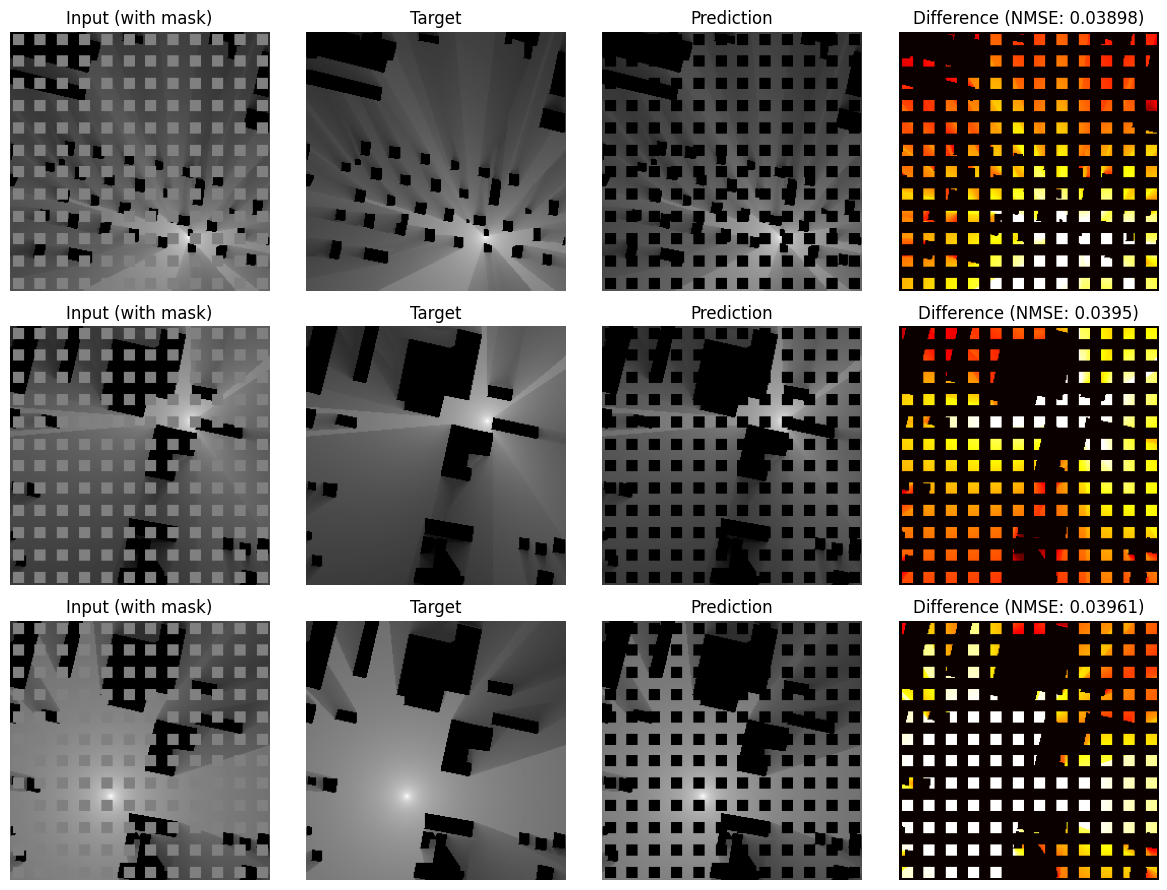

Validation: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]



Epoch 6: Train Loss: 0.001989, Train NMSE: 0.0002018
         Val Loss: 0.003121, Val NMSE: 0.0005223
保存最佳模型 (NMSE: 0.0005223)


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.53it/s]



Epoch 7: Train Loss: 0.001078, Train NMSE: 4.2e-05
         Val Loss: 0.00272, Val NMSE: 0.0004549
保存最佳模型 (NMSE: 0.0004549)


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]



Epoch 8: Train Loss: 0.0009616, Train NMSE: 3.443e-05
         Val Loss: 0.003757, Val NMSE: 0.0006155


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]



Epoch 9: Train Loss: 0.0009281, Train NMSE: 3.287e-05
         Val Loss: 0.002768, Val NMSE: 0.0004513
保存最佳模型 (NMSE: 0.0004513)


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.54it/s]



Epoch 10: Train Loss: 0.0008366, Train NMSE: 2.606e-05
         Val Loss: 0.003232, Val NMSE: 0.0005787


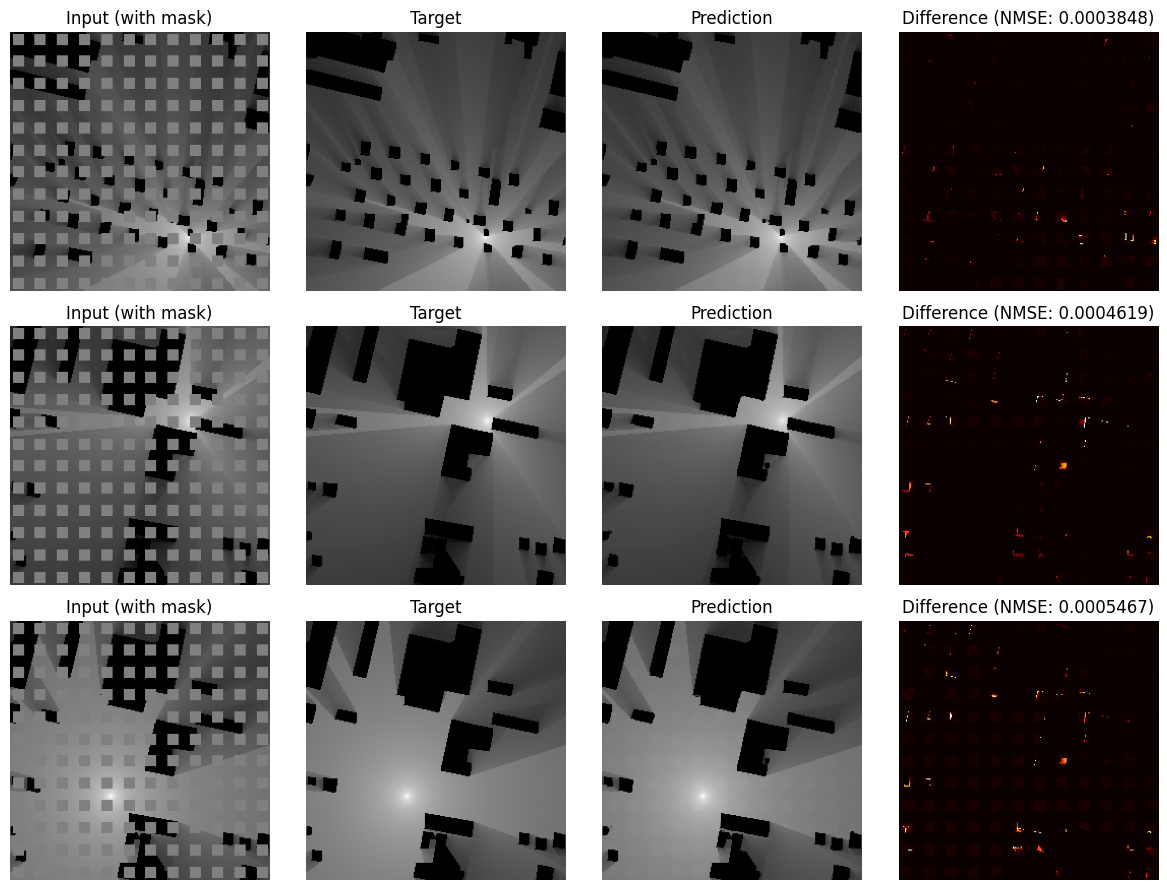

Validation: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]



Epoch 11: Train Loss: 0.0007874, Train NMSE: 2.367e-05
         Val Loss: 0.002747, Val NMSE: 0.0004605


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]



Epoch 12: Train Loss: 0.0007546, Train NMSE: 2.145e-05
         Val Loss: 0.002873, Val NMSE: 0.0005196


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.59it/s]



Epoch 13: Train Loss: 0.0007243, Train NMSE: 1.966e-05
         Val Loss: 0.003259, Val NMSE: 0.0004968


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.55it/s]



Epoch 14: Train Loss: 0.0006972, Train NMSE: 1.802e-05
         Val Loss: 0.002547, Val NMSE: 0.0004542


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.55it/s]


Epoch 15: Train Loss: 0.0006732, Train NMSE: 1.685e-05
         Val Loss: 0.002576, Val NMSE: 0.0004658


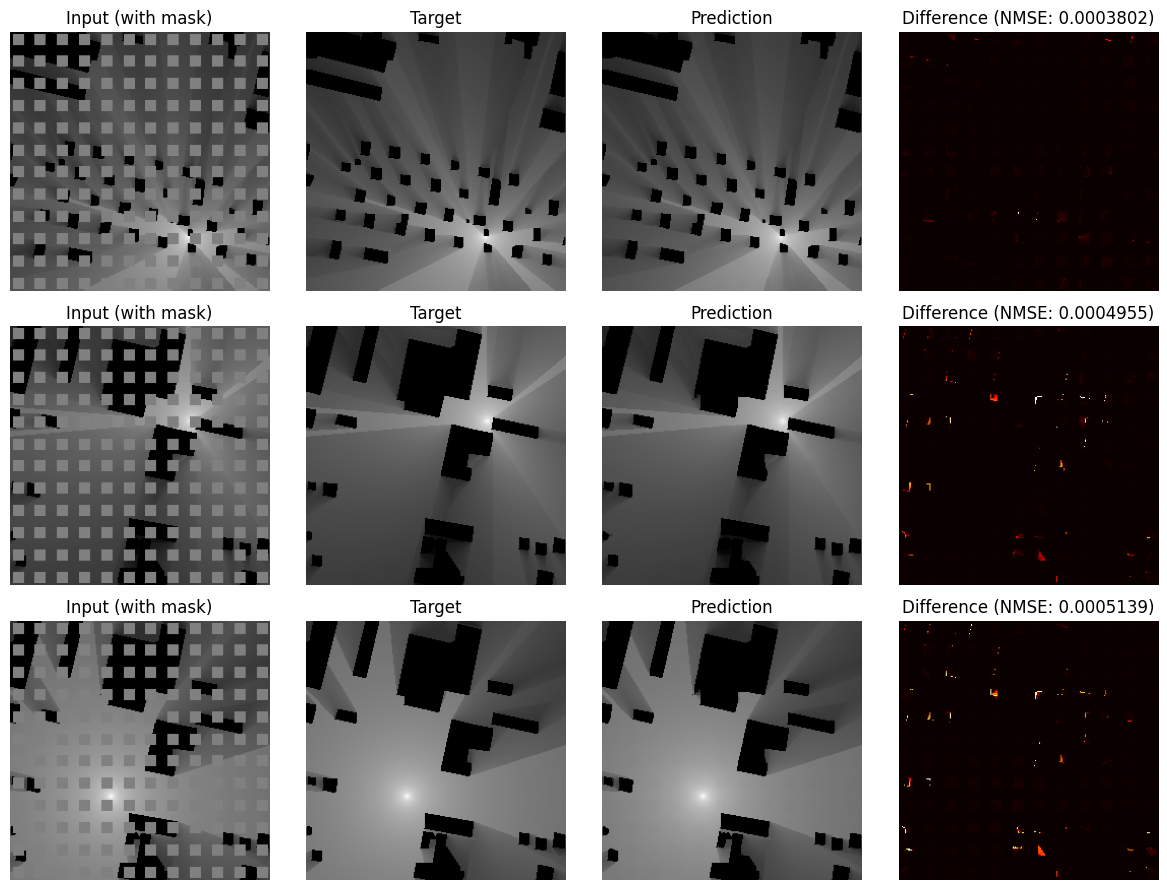

Validation: 100%|██████████| 154/154 [00:18<00:00,  8.51it/s]



Epoch 16: Train Loss: 0.0006462, Train NMSE: 1.564e-05
         Val Loss: 0.00325, Val NMSE: 0.0005348


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.52it/s]



Epoch 17: Train Loss: 0.000644, Train NMSE: 1.574e-05
         Val Loss: 0.004578, Val NMSE: 0.0006899


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.52it/s]



Epoch 18: Train Loss: 0.0006221, Train NMSE: 1.43e-05
         Val Loss: 0.002874, Val NMSE: 0.0004646


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.54it/s]



Epoch 19: Train Loss: 0.0005948, Train NMSE: 1.313e-05
         Val Loss: 0.003131, Val NMSE: 0.0005926


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.51it/s]



Epoch 20: Train Loss: 0.0005873, Train NMSE: 1.283e-05
         Val Loss: 0.002751, Val NMSE: 0.0004873


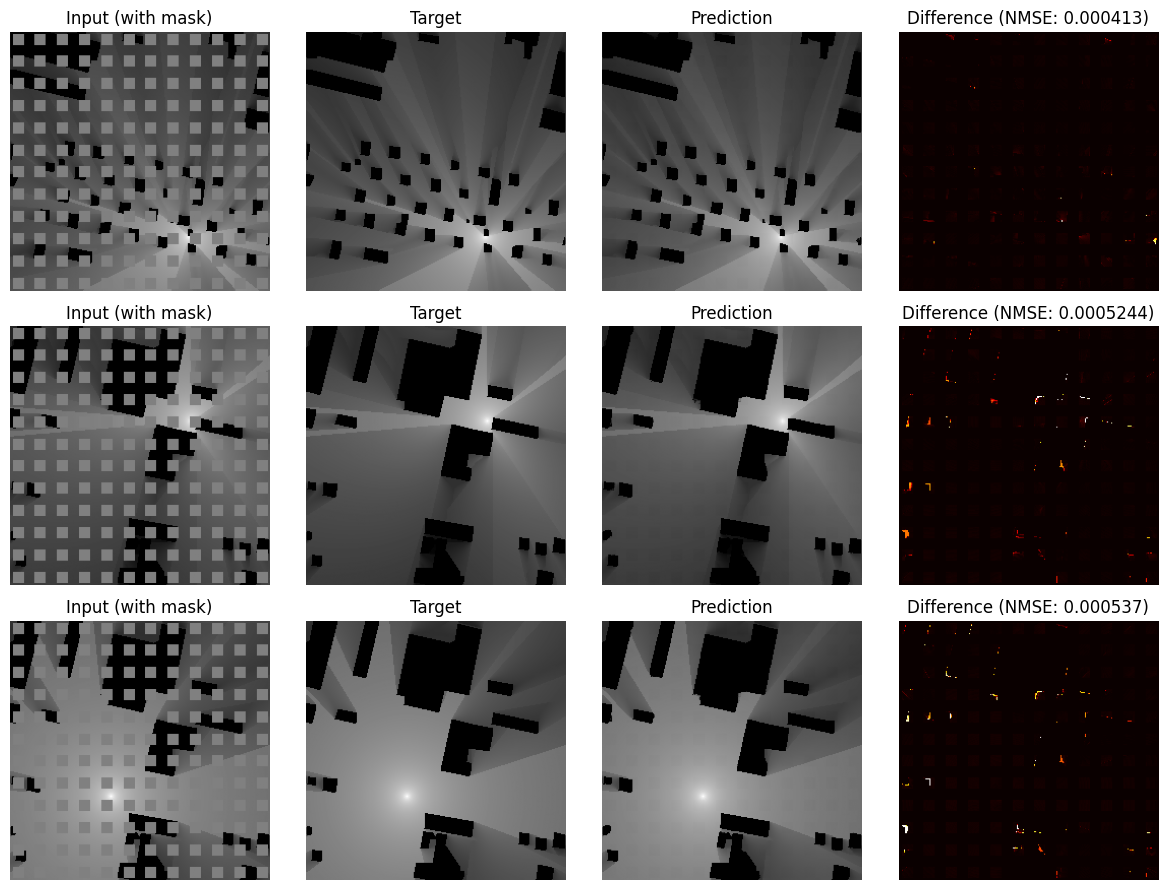

Validation: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]



Epoch 21: Train Loss: 0.0005791, Train NMSE: 1.244e-05
         Val Loss: 0.003776, Val NMSE: 0.0007261


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.56it/s]



Epoch 22: Train Loss: 0.0005632, Train NMSE: 1.195e-05
         Val Loss: 0.002753, Val NMSE: 0.0004523


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.55it/s]



Epoch 23: Train Loss: 0.0005522, Train NMSE: 1.139e-05
         Val Loss: 0.002799, Val NMSE: 0.0005173


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.49it/s]



Epoch 24: Train Loss: 0.0005453, Train NMSE: 1.104e-05
         Val Loss: 0.002913, Val NMSE: 0.0004725


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.53it/s]


Epoch 25: Train Loss: 0.0005313, Train NMSE: 1.043e-05
         Val Loss: 0.002501, Val NMSE: 0.0004593


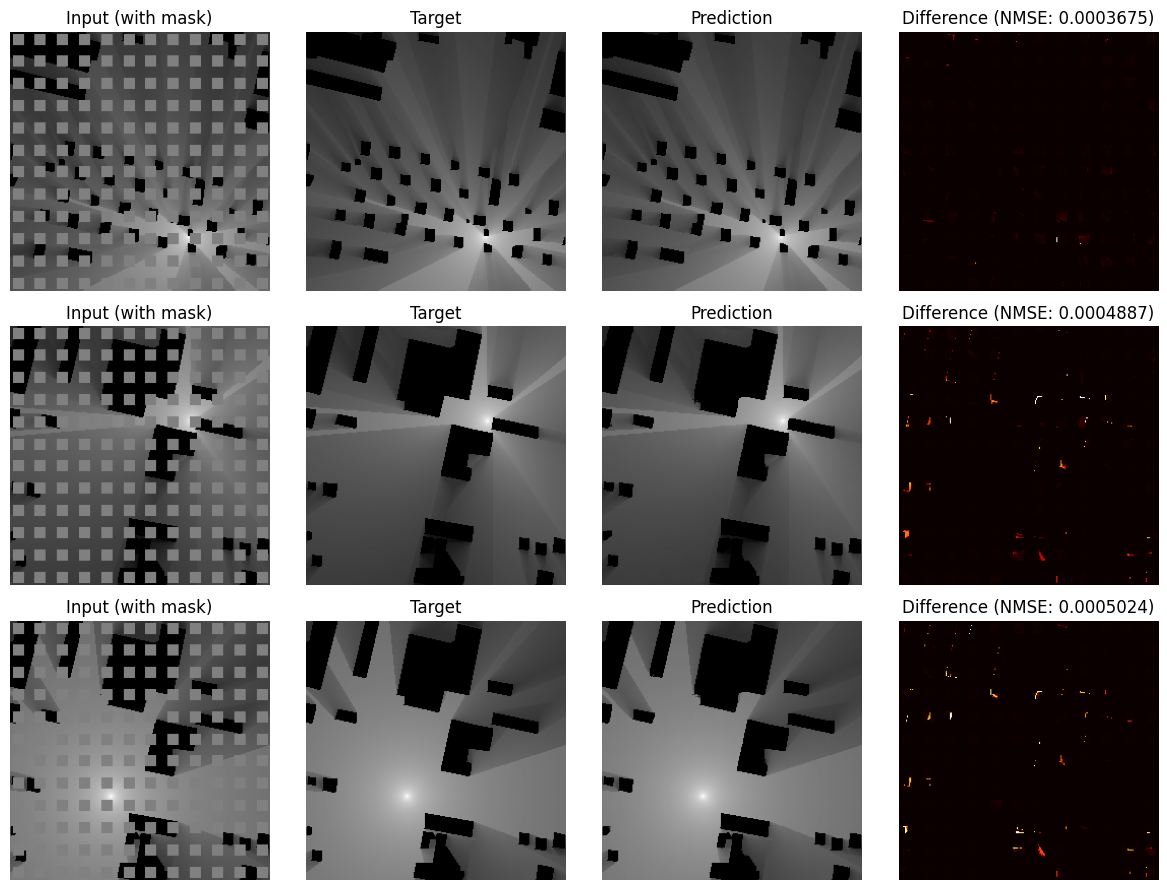

Validation: 100%|██████████| 154/154 [00:18<00:00,  8.49it/s]



Epoch 26: Train Loss: 0.0005274, Train NMSE: 1.043e-05
         Val Loss: 0.002775, Val NMSE: 0.000453


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.50it/s]



Epoch 27: Train Loss: 0.0005138, Train NMSE: 9.935e-06
         Val Loss: 0.002398, Val NMSE: 0.0004446
保存最佳模型 (NMSE: 0.0004446)


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.51it/s]



Epoch 28: Train Loss: 0.0005083, Train NMSE: 9.603e-06
         Val Loss: 0.003013, Val NMSE: 0.0005377


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.51it/s]



Epoch 29: Train Loss: 0.0005052, Train NMSE: 9.711e-06
         Val Loss: 0.00269, Val NMSE: 0.0004682


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.49it/s]


Epoch 30: Train Loss: 0.0004972, Train NMSE: 9.424e-06
         Val Loss: 0.002644, Val NMSE: 0.0004534


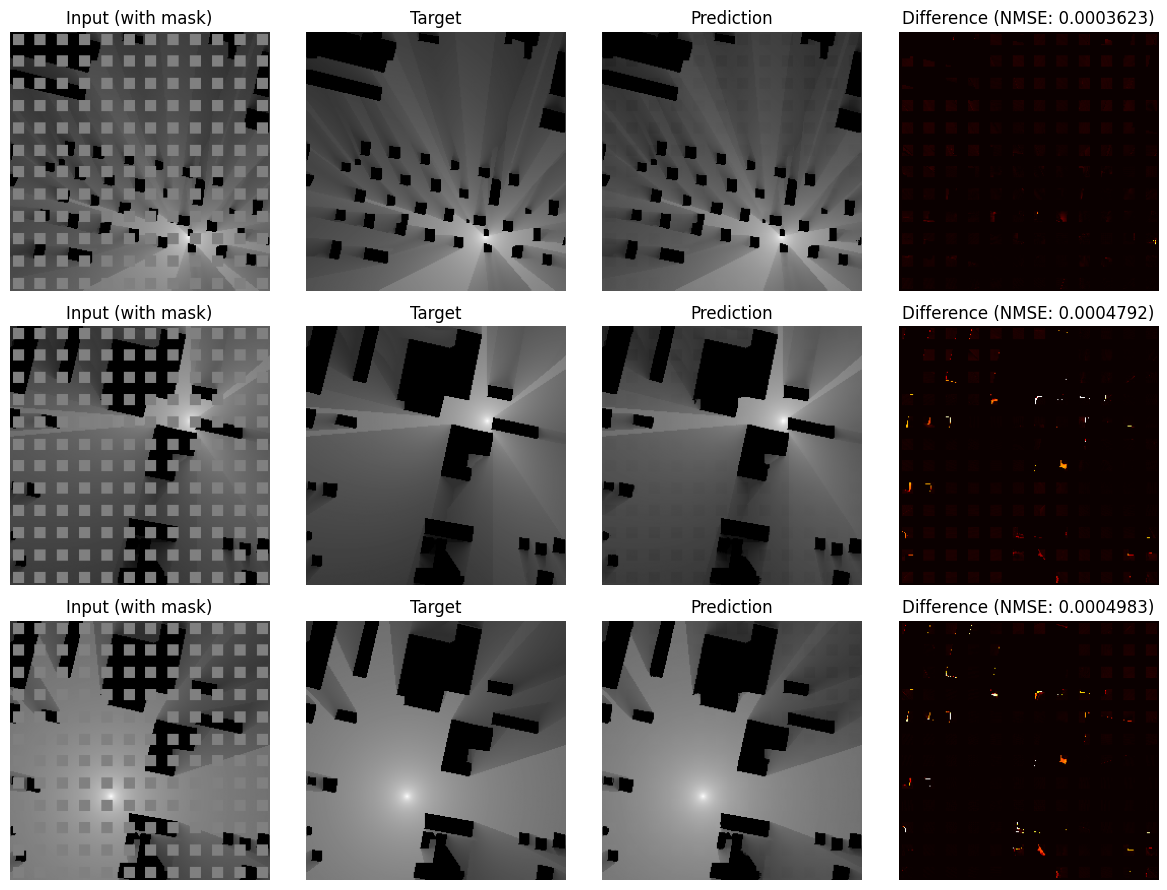

Validation: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]



Epoch 31: Train Loss: 0.0004192, Train NMSE: 6.26e-06
         Val Loss: 0.002325, Val NMSE: 0.0004344
保存最佳模型 (NMSE: 0.0004344)


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.54it/s]



Epoch 32: Train Loss: 0.000413, Train NMSE: 6.016e-06
         Val Loss: 0.002342, Val NMSE: 0.0004323
保存最佳模型 (NMSE: 0.0004323)


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]



Epoch 33: Train Loss: 0.0004067, Train NMSE: 5.884e-06
         Val Loss: 0.003246, Val NMSE: 0.0005957


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.48it/s]



Epoch 34: Train Loss: 0.0004044, Train NMSE: 6.028e-06
         Val Loss: 0.002289, Val NMSE: 0.0004371


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.56it/s]



Epoch 35: Train Loss: 0.0003973, Train NMSE: 5.728e-06
         Val Loss: 0.002287, Val NMSE: 0.0004375


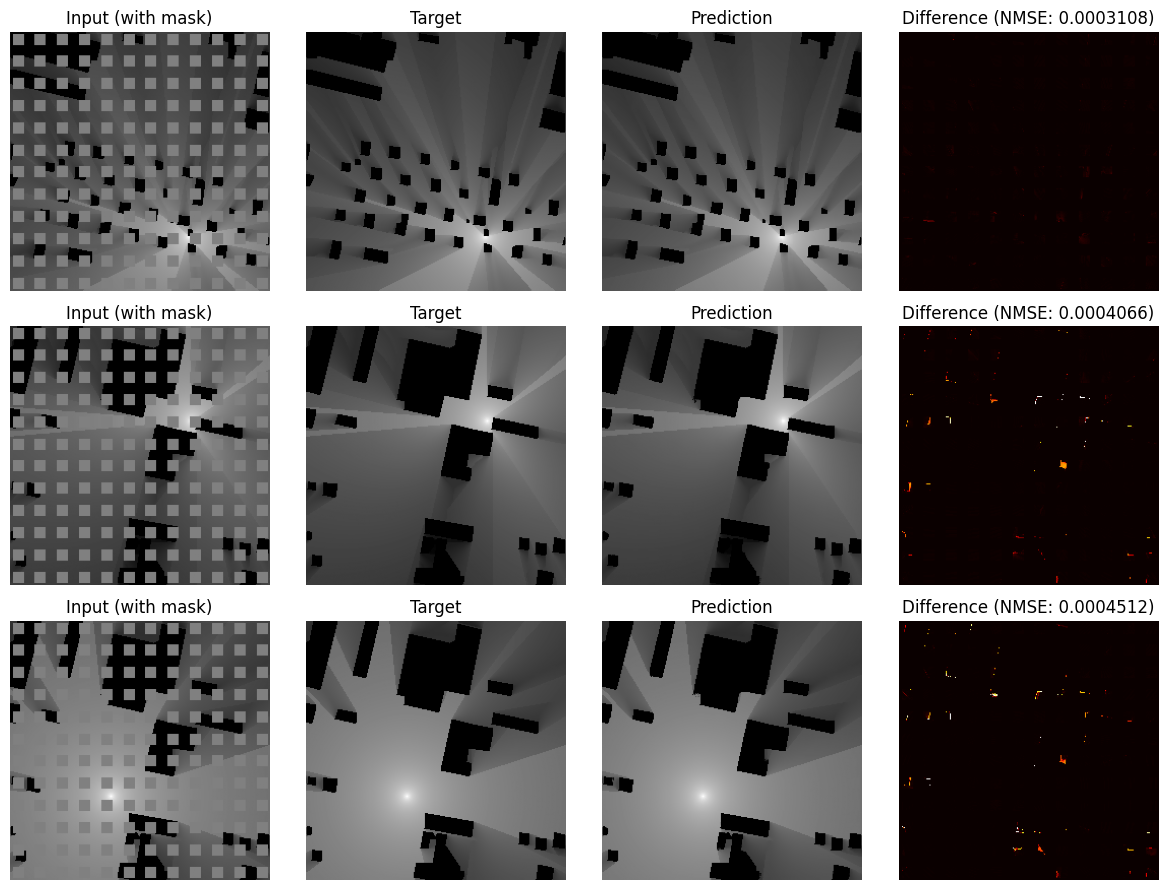

Validation: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]



Epoch 36: Train Loss: 0.0003939, Train NMSE: 5.673e-06
         Val Loss: 0.002294, Val NMSE: 0.0004297
保存最佳模型 (NMSE: 0.0004297)


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.54it/s]



Epoch 37: Train Loss: 0.0003899, Train NMSE: 5.588e-06
         Val Loss: 0.002283, Val NMSE: 0.000436


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]



Epoch 38: Train Loss: 0.0003879, Train NMSE: 5.496e-06
         Val Loss: 0.002417, Val NMSE: 0.0004635


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.58it/s]



Epoch 39: Train Loss: 0.0003828, Train NMSE: 5.391e-06
         Val Loss: 0.002291, Val NMSE: 0.0004311


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.61it/s]


Epoch 40: Train Loss: 0.0003802, Train NMSE: 5.372e-06
         Val Loss: 0.002292, Val NMSE: 0.000436


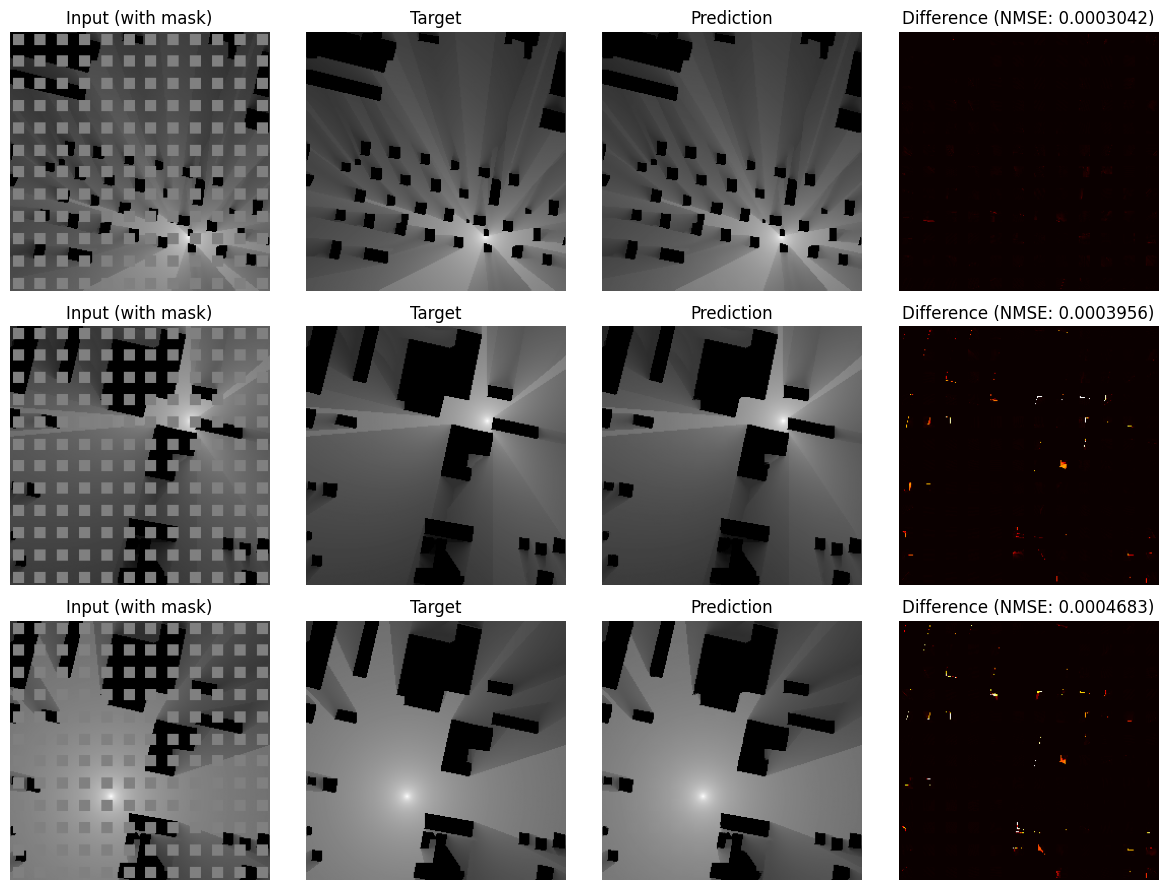

Validation: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]



Epoch 41: Train Loss: 0.0003806, Train NMSE: 5.407e-06
         Val Loss: 0.002884, Val NMSE: 0.000495


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.57it/s]



Epoch 42: Train Loss: 0.0003785, Train NMSE: 5.377e-06
         Val Loss: 0.002411, Val NMSE: 0.0004427


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.63it/s]



Epoch 43: Train Loss: 0.0003715, Train NMSE: 5.124e-06
         Val Loss: 0.002265, Val NMSE: 0.000433


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.60it/s]



Epoch 44: Train Loss: 0.0003715, Train NMSE: 5.067e-06
         Val Loss: 0.002306, Val NMSE: 0.0004371


Validation: 100%|██████████| 154/154 [00:18<00:00,  8.55it/s]



Epoch 45: Train Loss: 0.0003709, Train NMSE: 5.141e-06
         Val Loss: 0.002298, Val NMSE: 0.0004352


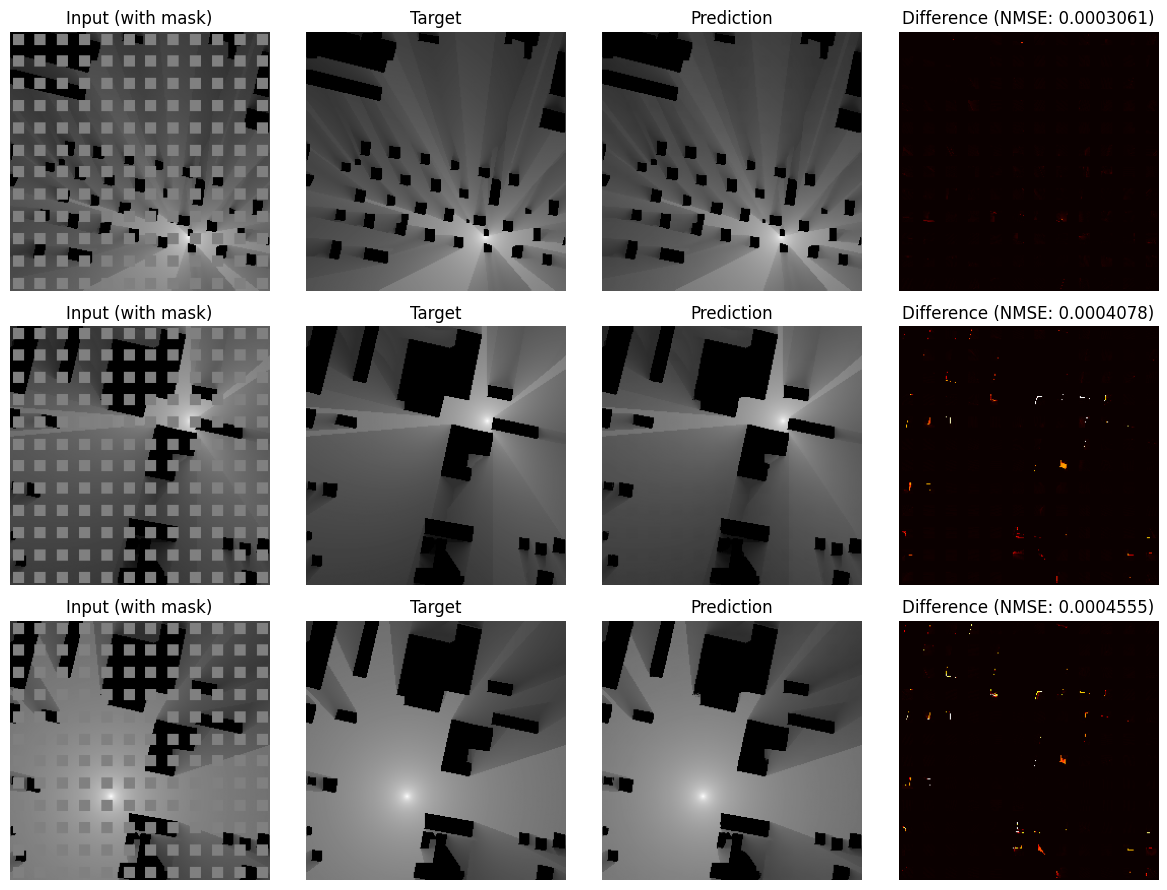

Validation: 100%|██████████| 154/154 [00:17<00:00,  8.59it/s]



Epoch 46: Train Loss: 0.0003665, Train NMSE: 5.055e-06
         Val Loss: 0.002364, Val NMSE: 0.0004362


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.56it/s]



Epoch 47: Train Loss: 0.0003649, Train NMSE: 5.066e-06
         Val Loss: 0.002383, Val NMSE: 0.0004379


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.61it/s]



Epoch 48: Train Loss: 0.0003628, Train NMSE: 4.94e-06
         Val Loss: 0.00249, Val NMSE: 0.0004508


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.61it/s]



Epoch 49: Train Loss: 0.0003597, Train NMSE: 4.879e-06
         Val Loss: 0.002464, Val NMSE: 0.0004516


Validation: 100%|██████████| 154/154 [00:17<00:00,  8.59it/s]



Epoch 50: Train Loss: 0.0003589, Train NMSE: 4.89e-06
         Val Loss: 0.0023, Val NMSE: 0.0004354


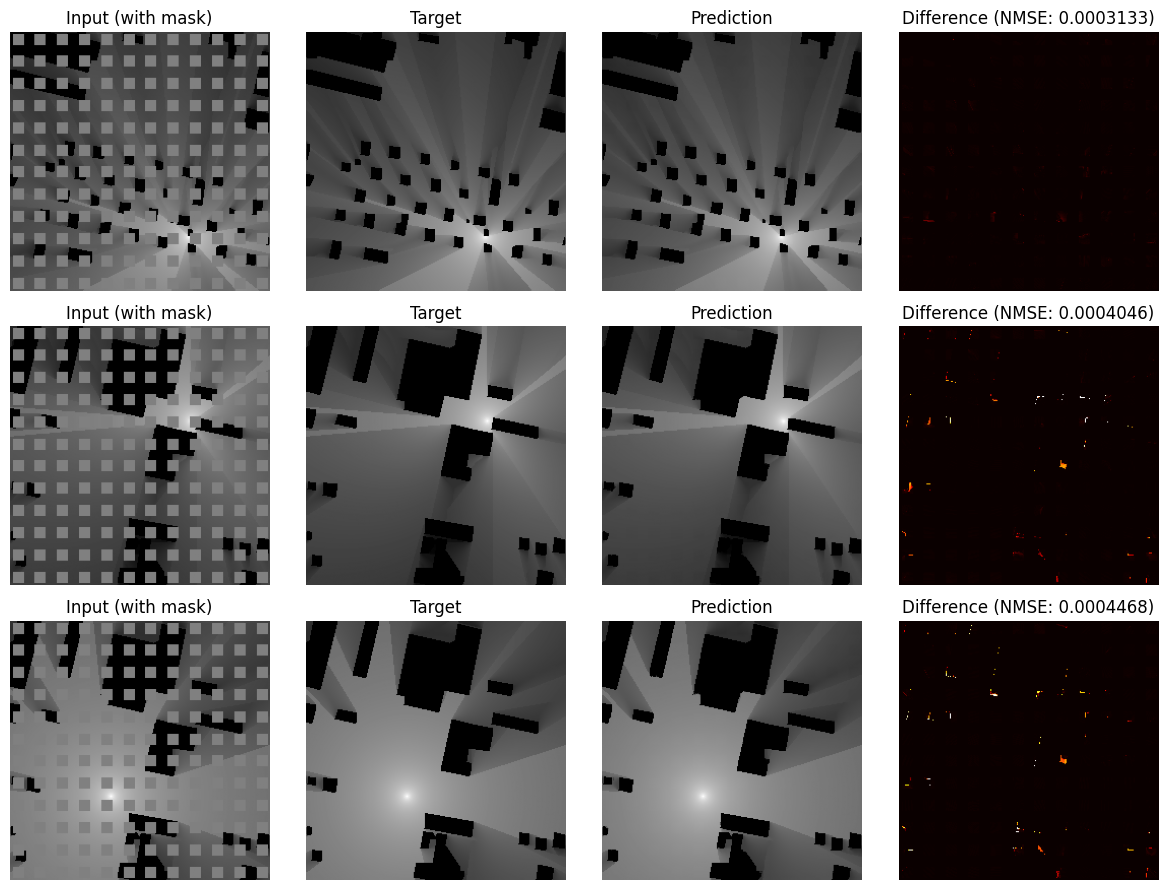


训练完成! 最佳模型: Epoch 36, NMSE: 0.0004297


In [8]:
# 初始化模型
if config.model_type == 'resnet':
    model = ResnetGenerator(
        input_nc=2,  # 输入: 遮罩图像 + 遮罩
        output_nc=1,
        ngf=config.ngf,
        n_blocks=config.n_blocks,
        use_dropout=config.use_dropout
    )
else:
    model = SimpleUNet(in_channels=2, out_channels=1)

model = model.to(device)

# 损失函数
criterion = CombinedLoss(
    mse_weight=config.mse_weight,
    tv_weight=config.tv_weight,
    grad_weight=config.grad_weight
)
criterion = criterion.to(device)  # 将损失函数也移动到GPU

# 优化器
optimizer = optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    betas=(config.beta1, config.beta2)
)

# 学习率调度器
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)

# 训练历史
history = {
    'train_loss': [],
    'train_nmse': [],
    'val_loss': [],
    'val_nmse': []
}

best_val_nmse = float('inf')
best_epoch = 0

# 训练循环
print("开始训练（组合损失方法）...")
for epoch in range(1, config.epochs + 1):
    # 训练
    train_loss, train_nmse = train_epoch(
        model, train_loader, criterion, optimizer, device, epoch, config
    )
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['train_nmse'].append(train_nmse)
    
    # 验证
    if epoch % config.val_interval == 0:
        val_loss, val_nmse = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_nmse'].append(val_nmse)
        
        print(f"\nEpoch {epoch}: Train Loss: {train_loss:.4g}, Train NMSE: {train_nmse:.4g}")
        print(f"         Val Loss: {val_loss:.4g}, Val NMSE: {val_nmse:.4g}")
        
        # 保存最佳模型
        if val_nmse < best_val_nmse:
            best_val_nmse = val_nmse
            best_epoch = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_nmse': val_nmse,
            }, os.path.join(MODEL_PATH, 'best_model.pth'))
            print(f"保存最佳模型 (NMSE: {val_nmse:.4g})")
        
        # 可视化结果
        if epoch % 5 == 0:
            visualize_results(model, val_loader, device, num_samples=3)
    
    # 调整学习率
    scheduler.step()
    
    # 定期保存模型
    if epoch % config.save_interval == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
        }, os.path.join(MODEL_PATH, f'checkpoint_epoch_{epoch}.pth'))

print(f"\n训练完成! 最佳模型: Epoch {best_epoch}, NMSE: {best_val_nmse:.4g}")

## 9. 绘制训练曲线

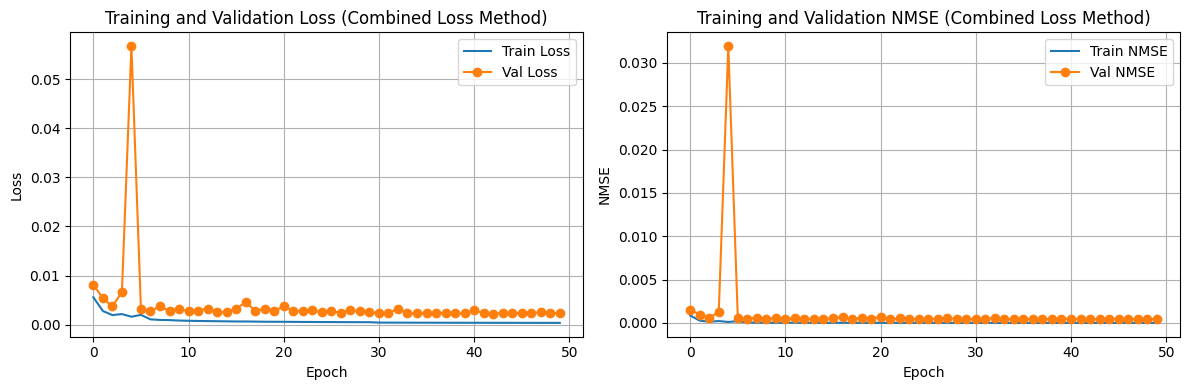

In [9]:
# 绘制训练历史
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 损失曲线
ax1.plot(history['train_loss'], label='Train Loss')
if history['val_loss']:
    ax1.plot(np.arange(config.val_interval-1, len(history['train_loss']), config.val_interval), 
             history['val_loss'], label='Val Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss (Combined Loss Method)')
ax1.legend()
ax1.grid(True)

# NMSE曲线
ax2.plot(history['train_nmse'], label='Train NMSE')
if history['val_nmse']:
    ax2.plot(np.arange(config.val_interval-1, len(history['train_nmse']), config.val_interval), 
             history['val_nmse'], label='Val NMSE', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('NMSE')
ax2.set_title('Training and Validation NMSE (Combined Loss Method)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'training_curves.png'), dpi=300)
plt.show()

## 10. 测试集预测

In [10]:
# 加载最佳模型
checkpoint = torch.load(os.path.join(MODEL_PATH, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"加载最佳模型 (Epoch {checkpoint['epoch']}, Val NMSE: {checkpoint['val_nmse']:.4g})")

# 预测测试集
model.eval()
predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        # 准备数据
        input_img = batch['input'].to(device)
        original_img = batch['original'].to(device)  # 使用原始图像
        mask = batch['mask'].to(device)
        filename = batch['filename'][0]
        
        # 拼接输入
        model_input = torch.cat([input_img, mask], dim=1)
        
        # 前向传播
        output = model(model_input)
        
        # 融合输出 - 关键修复
        final_output = original_img * mask + output * (1 - mask)
        
        # 保存预测结果
        output_np = (final_output[0, 0].cpu().numpy() * 255).astype(np.uint8)
        output_img = Image.fromarray(output_np, mode='L')
        
        # 保存图像
        output_path = os.path.join(OUTPUT_PATH, f'pred_{filename}')
        output_img.save(output_path)
        
        predictions.append({
            'filename': filename,
            'output_path': output_path
        })

print(f"\n测试完成! 预测结果保存在: {OUTPUT_PATH}")
print(f"共预测 {len(predictions)} 张图像")

加载最佳模型 (Epoch 36, Val NMSE: 0.0004297)


Testing: 100%|██████████| 7010/7010 [01:12<00:00, 97.31it/s] 


测试完成! 预测结果保存在: output_combined_loss
共预测 7010 张图像


## 11. 结果分析和可视化

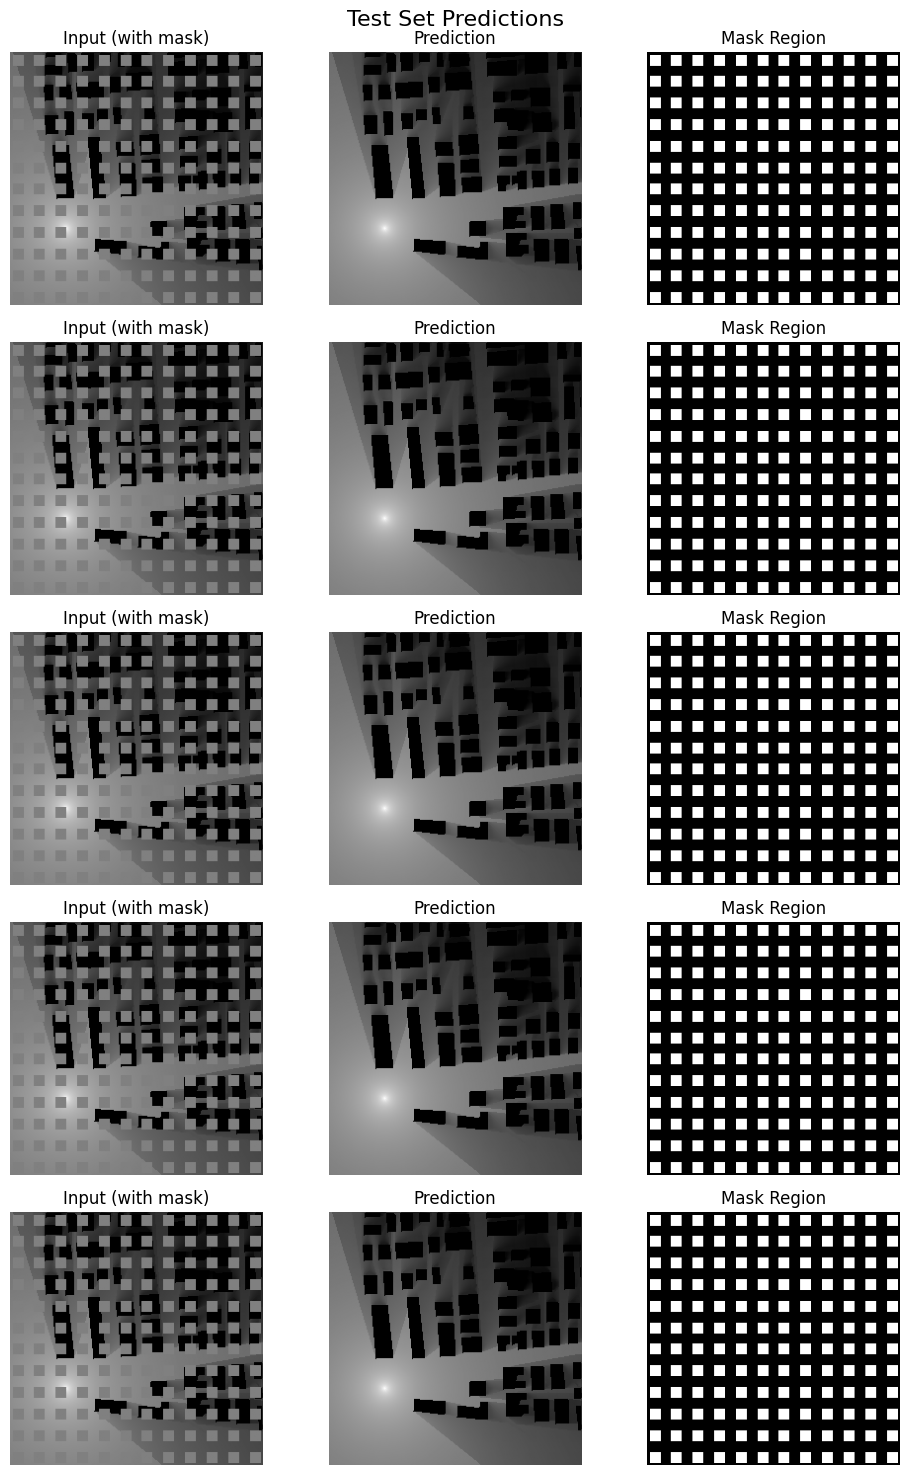

In [11]:
# 随机选择一些测试结果进行可视化
def visualize_test_results(test_loader, model, device, num_samples=6):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 3*num_samples))
    
    # 随机选择样本
    indices = np.random.choice(len(test_loader), num_samples, replace=False)
    
    with torch.no_grad():
        for idx, i in enumerate(indices):
            # 获取特定批次
            batch = next(iter(test_loader))
            
            # 准备数据
            input_img = batch['input'].to(device)
            original_img = batch['original'].to(device)
            mask = batch['mask'].to(device)
            
            # 拼接输入
            model_input = torch.cat([input_img, mask], dim=1)
            
            # 前向传播
            output = model(model_input)
            
            # 融合输出
            final_output = original_img * mask + output * (1 - mask)
            
            # 转换为numpy
            input_np = input_img[0, 0].cpu().numpy()
            output_np = final_output[0, 0].cpu().numpy()
            mask_np = mask[0, 0].cpu().numpy()
            
            # 显示图像
            axes[idx, 0].imshow(input_np, cmap='gray', vmin=0, vmax=1)
            axes[idx, 0].set_title('Input (with mask)')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(output_np, cmap='gray', vmin=0, vmax=1)
            axes[idx, 1].set_title('Prediction')
            axes[idx, 1].axis('off')
            
            # 遮罩区域
            axes[idx, 2].imshow(1-mask_np, cmap='gray', vmin=0, vmax=1)
            axes[idx, 2].set_title('Mask Region')
            axes[idx, 2].axis('off')
    
    plt.suptitle('Test Set Predictions', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'test_predictions.png'), dpi=300)
    plt.show()

# 执行可视化
visualize_test_results(test_loader, model, device, num_samples=5)

## 12. 总结和建议

In [12]:
print("="*60)
print("Radio Map补全任务 - 训练总结")
print("="*60)
print(f"\n模型架构: {config.model_type.upper()}")
print(f"总训练轮数: {config.epochs}")
print(f"最佳验证NMSE: {best_val_nmse:.4g} (Epoch {best_epoch})")
print(f"\n模型参数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"训练数据量: {len(train_dataset)} 张图像")
print(f"验证数据量: {len(val_dataset)} 张图像")
print(f"测试数据量: {len(test_dataset)} 张图像")

Radio Map补全任务 - 训练总结

模型架构: RESNET
总训练轮数: 50
最佳验证NMSE: 0.0004297 (Epoch 36)

模型参数量: 17,609,377
训练数据量: 44163 张图像
验证数据量: 4907 张图像
测试数据量: 7010 张图像
